<a href="https://colab.research.google.com/github/realmiketalbot/CIVE580C3/blob/main/lectures/lecture4-ET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import folium
import numpy as np
import branca.colormap as cm
import pandas as pd
import os
import zipfile
import requests
from tqdm import tqdm

In [3]:
#if not ee.data._credentials:
ee.Authenticate()
ee.Initialize(project='ee-cive580c3-lecture3')

In [4]:
# functions needed for this lab (and some other useful ones that you can use if you're interested)

# this function is used to add a google earth engine layer to an existing folium map,
# for visualization purposes. Folium is a python package that can put rasters/shapefiles on a basemap
# the function below is run using an existing folium map. If the folium map defines is my_map, then
# my_map.add_ee_layer(ee_object,name)
# where ee_object is the object defined in google earth engine, and name is the label in folium
def add_ee_layer(self, ee_object, name):
    try:
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):
            range = ee.Image(ee_object).reduceRegion(ee.Reducer.percentile([1, 99]),scale=10000)
            vals = range.getInfo()
            min=list(vals.items())[0][1]
            max=list(vals.items())[1][1]
            vis = {'min': min, 'max': max, 'palette': ['0000FF', 'FFFFFF','FF0000']}

            map_id_dict = ee.Image(ee_object).getMapId(vis)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
            colormap = cm.LinearColormap(vmin=min,vmax=max,colors=['blue', 'white','red']).to_step(n=10)
            colormap.caption=name
            self.add_child(colormap)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)

    except Exception as e:
        print("Could not display {}".format(name))
        print(e)


# to convert a google earth engine image to a python array
def to_array(img,aoi):
  band_arrs = img.sampleRectangle(region=aoi,properties=['scale=1000'],defaultValue=-999)

  band_names=img.bandNames().getInfo()

  for kk in range(len(band_names)):
    if kk==0:
      dat1=np.array(band_arrs.get(band_names[kk]).getInfo())
      dat_full=np.zeros((dat1.shape[0],dat1.shape[1],len(band_names)))
      dat_full[:,:,kk]=dat1
    else:
      dat=np.array(band_arrs.get(band_names[kk]).getInfo())
      dat_full[:,:,kk]=dat
  return(dat_full)

# to calculate an index
def getIndex(image,b1,b2):
  return image.normalizedDifference([b1, b2])

# to calculate a ratio
def getRatio(image1,image2):
  ratio=image1.divide(image2)
  return ratio

# to create a color map from a specific image
def getVisparams(image,aoi):
  range = image.reduceRegion(ee.Reducer.percentile([1, 99]),aoi,300)
  vals = range.getInfo()
  min=list(vals.items())[0][1]
  max=list(vals.items())[1][1]
  visParams = {'min': min, 'max': max, 'palette': ['0000FF', 'FFFFFF','FF0000']}
  return(visParams)

# to get the link to download an earth engine image
def getLink(image,fname,aoi,scale=1000):
  link = image.getDownloadURL({
    'scale': scale,
    'crs': 'EPSG:4326',
    'fileFormat': 'GeoTIFF',
    'region': aoi,
    'name': fname})
  # print(link)
  return(link)

def download_img(img,geom,fname,scale=1000):
    linkname = getLink(img,fname,geom,scale=scale)
    response = requests.get(linkname, stream=True)
    zipped = fname+'.zip'
    with open(zipped, "wb") as handle:
        for data in tqdm(response.iter_content()):
            handle.write(data)

    with zipfile.ZipFile(zipped, 'r') as zip_ref:
        zip_ref.extractall('')
    os.remove(zipped)

# create an earth engine geometry polygon
def addGeometry(min_lon,max_lon,min_lat,max_lat):

  geom = ee.Geometry.Polygon(
      [[[min_lon, max_lat],
        [min_lon, min_lat],
        [max_lon, min_lat],
        [max_lon, max_lat]]])
  return(geom)

def get_imgcollection(date1,date2,geometry,collection_name,band_name,function='mean'):
  collection = ee.ImageCollection(collection_name)
  if function=='mean':
      img = collection.filterDate(date1,date2).select(band_name).mean().clip(geometry)
  if function=='sum':
      img = collection.filterDate(date1,date2).select(band_name).sum().clip(geometry)
 # range = img.reduceRegion(ee.Reducer.percentile([1, 99]),scale=10000)
 # vals = range.getInfo()
 # min=list(vals.items())[0][1]
 # max=list(vals.items())[1][1]
 # visParams = {'min': min, 'max': max, 'palette': ['0000FF', 'FFFFFF','FF0000']}
  return(img)

# load prism data
def get_prism_image(date1,date2,geometry):

  prism = ee.ImageCollection('OREGONSTATE/PRISM/AN81m')
  prism_img = prism.filterDate(date1,date2).select('ppt').mean().clip(geometry)
  return(prism_img) # returns prism average monthly precipitation, in mm

# load landsat 8 data
def get_l8_image(date1,date2,geometry):

  l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_RT')
  l8_img = l8.filterDate(date1,date2).mean().clip(geometry)
  return(l8_img)

# to export an image to google drive
def export_to_drive(raster,filename,foldername,geometry):
  # Export the image, specifying scale and region.
  task = ee.batch.Export.image.toDrive(**{
      'image': raster,
      'description': filename,
      'folder': foldername,
      'fileNamePrefix': filename,
      'scale': 1000,
      'region': geometry,
      'fileFormat': 'GeoTIFF',
      'formatOptions': {
        'cloudOptimized': 'true'
      },
  })
  task.start()

# to create an elevation raster from the USGS NED in google earth engine from a user-defined geometry
def get_elev(geometry):

  elev = ee.Image('USGS/NED').clip(geometry)
  return(elev)

# to create an elevation raster from the SRTM in google earth engine from a user-defined geometry
def get_srtm(geometry):

  elev = ee.Image('USGS/SRTMGL1_003').clip(geometry)
  return(elev)

# to create a temporally averaged precipitation raster from GPM from a user-defined geometry
def get_gpm_image(date1,date2,geometry):

  gpm = ee.ImageCollection('NASA/GPM_L3/IMERG_MONTHLY_V07')
  gpm_img = gpm.filterDate(date1,date2).select('precipitation').mean().multiply(24*365/12).clip(geometry) # convert from mm/hour to mm/month
  return(gpm_img) # returns gpm average monthly precipitation in mm

# to create a temporally averaged actual ET raster from the openET ensemble from a user-defined geometry
def get_openET_image(date1,date2,geometry):

  openET = ee.ImageCollection('OpenET/ENSEMBLE/CONUS/GRIDMET/MONTHLY/v2_0')
  openET_img = openET.filterDate(date1,date2).select('et_ensemble_mad').mean().clip(geometry)
  return(openET_img)

# to create a temporally averaged reference ET raster from the openET ensemble from a user-defined geometry
def get_RET(date1,date2,geometry):

  ETR = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET')
  ETR_image = ETR.filterDate(date1,date2).select('etr').mean().multiply(365/12).clip(geometry) # convert from mm/day to mm/month
  return(ETR_image)

# load sentinel 2 data
def get_s2_image(date1,date2,geometry):

    s2 = ee.ImageCollection('COPERNICUS/S2')
    s2_img = s2.filterDate(date1,date2).filterBounds(geometry).first().clip(geometry)
    return(s2_img)

# Add EE drawing method to folium (not a function)
folium.Map.add_ee_layer = add_ee_layer

def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):
  """Creates a region reduction function.

  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.

  Args:
    geometry:
      An ee.Geometry that defines the region over which to reduce data.
    reducer:
      Optional; An ee.Reducer that defines the reduction method.
    scale:
      Optional; A number that defines the nominal scale in meters of the
      projection to work in.
    crs:
      Optional; An ee.Projection or EPSG string ('EPSG:5070') that defines
      the projection to work in.
    bestEffort:
      Optional; A Boolean indicator for whether to use a larger scale if the
      geometry contains too many pixels at the given scale for the operation
      to succeed.
    maxPixels:
      Optional; A number specifying the maximum number of pixels to reduce.
    tileScale:
      Optional; A number representing the scaling factor used to reduce
      aggregation tile size; using a larger tileScale (e.g. 2 or 4) may enable
      computations that run out of memory with the default.

  Returns:
    A function that accepts an ee.Image and reduces it by region, according to
    the provided arguments.
  """

  def reduce_region_function(img):
    """Applies the ee.Image.reduceRegion() method.

    Args:
      img:
        An ee.Image to reduce to a statistic by region.

    Returns:
      An ee.Feature that contains properties representing the image region
      reduction results per band and the image timestamp formatted as
      milliseconds from Unix epoch (included to enable time series plotting).
    """

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

# generate data frame from image collection
def gee_zonal_mean_img_coll(imageCollection,geometry,scale=1000):
    reduce_iC = create_reduce_region_function(geometry = geometry, scale=scale)
    stat_fc = ee.FeatureCollection(imageCollection.map(reduce_iC)).filter(ee.Filter.notNull(imageCollection.first().bandNames()))
    fc_dict = fc_to_dict(stat_fc).getInfo()

    df = pd.DataFrame(fc_dict)
    df['date'] = pd.to_datetime(df['millis'],unit='ms')
    return(df)

def gee_zonal_mean(date1,date2,geometry,collection_name,band_name,scale=1000):
     imcol = ee.ImageCollection(collection_name).select(band_name).filterDate(date1,date2)
     df = gee_zonal_mean_img_coll(imcol,geometry,scale=scale)
     return(df)


In [40]:
# create a bounding box that defines the study area
# geom = addGeometry(-109, -102,37,41) # min long, max long, min lat, max lat (colorado)
geom = addGeometry(-101.1, -101,37.9,38) # min long, max long, min lat, max lat (kansas)

# define dates of interest (inclusive).
start = '2019-10-01'
end = '2020-10-01' #can go up to april 2021

# get elevation data
elev = get_elev(geom)

# download ET data from openET
et_img = get_imgcollection(start, end, geom, "OpenET/ENSEMBLE/CONUS/GRIDMET/MONTHLY/v2_0", "et_ensemble_mad", function='mean')

download_img(et_img, geom, "OpenET", 100)

28142it [00:00, 155081.10it/s]


In [26]:
#add ET and elevation to folium map
my_map = folium.Map(location=[37.95,-101.05],zoom_start=12)
my_map.add_ee_layer(geom, 'Bounding Box')
my_map.add_ee_layer(elev, 'Elevation')
my_map.add_ee_layer(et_img, 'ET (mm/month)')

In [27]:
# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

Get reference ET time series over the same area

(0.0, 15.0)

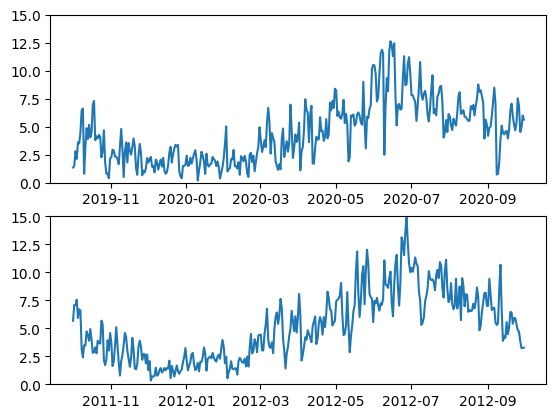

In [33]:
# plot a time series of reference ET
eto_2020 = gee_zonal_mean("2019-10-01", "2020-10-01", geom, "IDAHO_EPSCOR/GRIDMET", "eto")
eto_2012 = gee_zonal_mean("2011-10-01", "2012-10-01", geom, "IDAHO_EPSCOR/GRIDMET", "eto")

import matplotlib.pyplot as plt
plt.subplot(2,1,1)
plt.plot(eto_2020['date'],eto_2020['eto'],label='2020')
plt.ylim([0,15])
plt.subplot(2,1,2)
plt.plot(eto_2012['date'],eto_2012['eto'],label='2012')
plt.ylim([0,15])

Now, we will look at the semivariogram of ET

In [34]:
# install rasterio and pykrige
!pip install pykrige
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 71.9 MB/s eta 0:00:00


In [35]:
# load openET raster
import rasterio

r = rasterio.open('OpenET.et_ensemble_mad.tif')

In [36]:
# create 1d variables for x, y and ET
import numpy as np

data = r.read(1)
rows, cols = np.indices(data.shape)
xs, ys = rasterio.transform.xy(r.transform, rows, cols)
# Flatten the arrays
xs = np.array(xs).flatten()
ys = np.array(ys).flatten()
zs = data.flatten() # 1d variable for ET

print(zs)

[73.24074074 73.5        71.84259259 ... 48.77777778 50.60185185
 50.23148148]


Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 216.59137834625116
Full Sill: 397.8349020438661
Range: 0.08747214729726513
Nugget: 181.24352369761493 



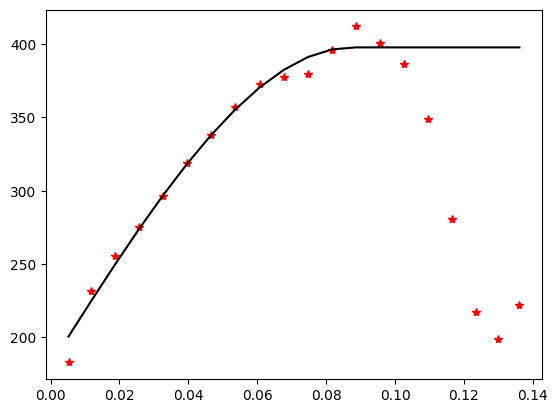

Calculating statistics on variogram model fit...


In [37]:
from pykrige.ok import OrdinaryKriging

OK = OrdinaryKriging(
    xs,
    ys,
    zs,
    variogram_model="spherical",
    nlags=20,
    weight=True,
    verbose=True,
    enable_plotting=True,
)

In [42]:
nir = get_imgcollection(start, end, geom, "COPERNICUS/S2_HARMONIZED", "B8", function='mean')
red = get_imgcollection(start, end, geom, "COPERNICUS/S2_HARMONIZED", "B4", function='mean')
swir = get_imgcollection(start, end, geom, "COPERNICUS/S2_HARMONIZED", "B12", function='mean')
green = get_imgcollection(start, end, geom, "COPERNICUS/S2_HARMONIZED", "B3", function='mean')
blue = get_imgcollection(start, end, geom, "COPERNICUS/S2_HARMONIZED", "B2", function='mean')

ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
ndwi = nir.subtract(swir).divide(nir.add(swir)).rename('NDWI')
gi = nir.divide(green).rename('GI')

In [43]:
download_img(ndvi, geom, "NDVI", 100)
download_img(ndwi, geom, "NDWI", 100)
download_img(gi, geom, "GI", 100)

96381it [00:00, 154613.73it/s]
96384it [00:01, 91197.06it/s]
95555it [00:00, 151601.31it/s]


Text(0, 0.5, 'GI')

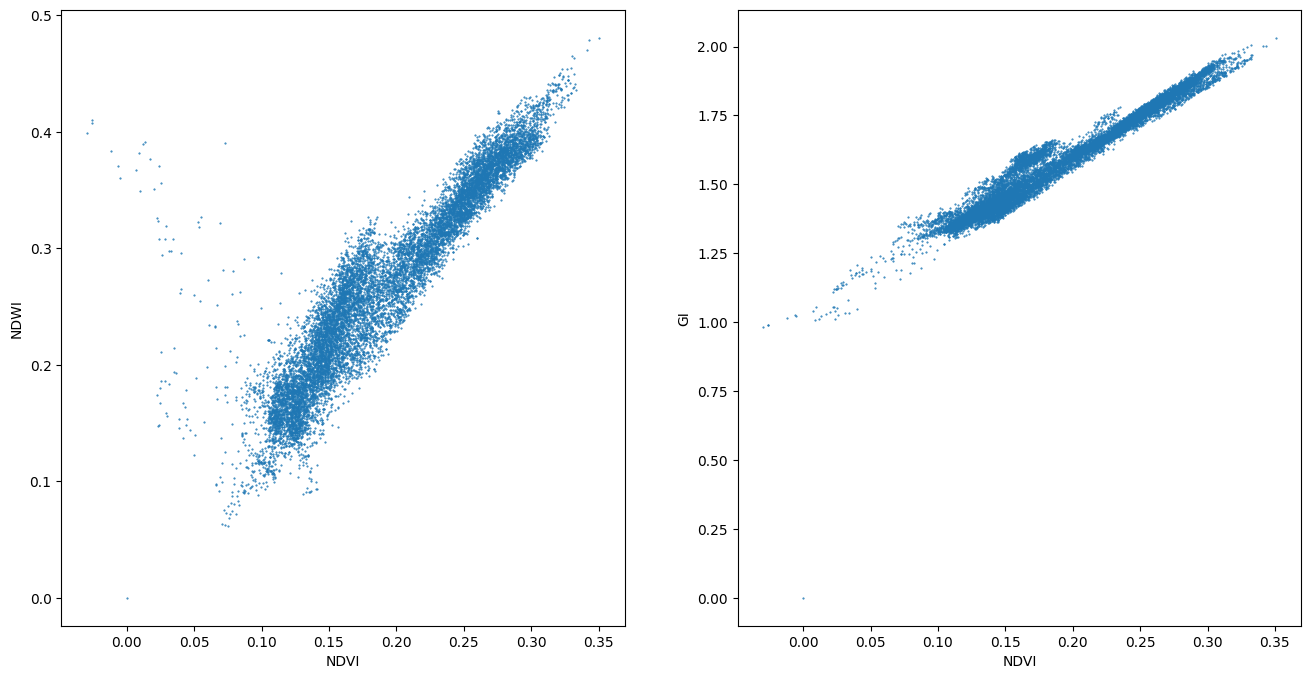

In [48]:
ndvi_r = rasterio.open('NDVI.NDVI.tif')
ndwi_r = rasterio.open('NDWI.NDWI.tif')
gi_r = rasterio.open('GI.GI.tif')

plt.figure(figsize=(16,8));
plt.subplot(1,2,1)
plt.plot(ndvi_r.read(1).flatten(),ndwi_r.read(1).flatten(),'.',markersize=1)
plt.xlabel('NDVI')
plt.ylabel('NDWI')
plt.subplot(1,2,2)
plt.plot(ndvi_r.read(1).flatten(),gi_r.read(1).flatten(),'.',markersize=1)
plt.xlabel('NDVI')
plt.ylabel('GI')
